Import necessary libraries

In [108]:
import matplotlib.pyplot as plt
# plt.plot([1])
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
import logging
import sys
from functools import partial
from pprint import pprint
import gdsfactory as gf
import jax.example_libraries.optimizers as opt
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange
import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH
from math import e
!pip install tqdm
import tqdm
import numpy as np
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

gf.config.set_plot_options(show_subports=False)


MZI circuit 

In [109]:
parameter_array = [10, 2, 2]


def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})

def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )

def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

def bend_euler_2(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.98 * v for k, v in straight(wl=wl, length=length).items()}

def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,

}

models_2 = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": waveguide,
}

mzi_component = gf.components.mzi(
    delta_length=parameter_array[0], length_x=parameter_array[2], length_y=parameter_array[1],
)
        
mzi_circuit, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models,
)

mzi_circuit_2, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models_2,
)
S = mzi_circuit(
    wl=1.53,
    syl={
        "length": parameter_array[0] / 2 + 2,
    },
    straight_9={
        "length": parameter_array[0] / 2 + 2,
    },
)


Loss Function Definition - for minima at target wavelength

For an initially set constant parameter (delta_length), and for a target wavelength, run optimization.

In [110]:

@jax.jit
def loss_fn(delta_length=30, opt_wl=1.55):
    wl_ = opt_wl
    S = mzi_circuit_2(
        wl=wl_,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

def step_fn(step, state, opt_wl):
    settings = params_fn(state)
    # print(settings)
    loss = loss_fn(settings, opt_wl)
    grad = grad_fn(settings, opt_wl)
    state = update_fn(step, grad, state)
    return loss, state


About nature of loss function

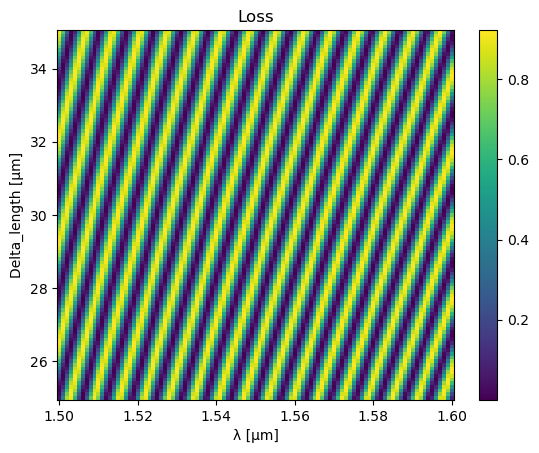

In [111]:
# Create arrays
wavelength_array = np.linspace(1.5, 1.6, 101)
delta_length_array = np.linspace(25, 35, 101)

loss_2D = np.zeros([101,101])

wavelength_counter = 0
length_counter = 0

for delta_length in  delta_length_array:
    wavelength_counter = 0
    for wavelength in  wavelength_array:
        loss = loss_fn(delta_length, wavelength)
        loss_2D[length_counter, wavelength_counter] = float(loss)
        wavelength_counter = wavelength_counter+1
    length_counter = length_counter+1

# Create mesh grids
delta_length_array, wavelength_array = np.meshgrid(delta_length_array, wavelength_array)

# Plotting
plt.pcolormesh(wavelength_array, delta_length_array, loss_2D)
plt.xlabel("λ [μm]")
plt.ylabel("Delta_length [μm]")
plt.colorbar()
plt.title("Loss")
plt.show()


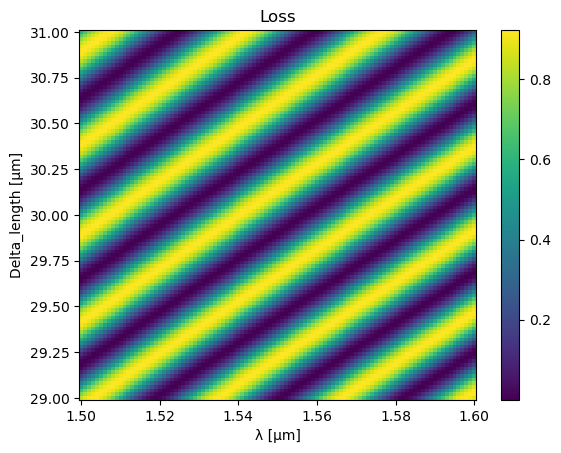

In [131]:
# Create arrays
wavelength_array = np.linspace(1.5, 1.6, 101)
delta_length_array = np.linspace(29, 31, 101)

loss_2D = np.zeros([101,101])

wavelength_counter = 0
length_counter = 0

for delta_length in  delta_length_array:
    wavelength_counter = 0
    for wavelength in  wavelength_array:
        loss = loss_fn(delta_length, wavelength)
        loss_2D[length_counter, wavelength_counter] = float(loss)
        wavelength_counter = wavelength_counter+1
    length_counter = length_counter+1

# Create mesh grids
delta_length_array, wavelength_array = np.meshgrid(delta_length_array, wavelength_array)

# Plotting
plt.pcolormesh(wavelength_array, delta_length_array, loss_2D)
plt.xlabel("λ [μm]")
plt.ylabel("Delta_length [μm]")
plt.colorbar()
plt.title("Loss")
plt.show()


Alternative illustration method

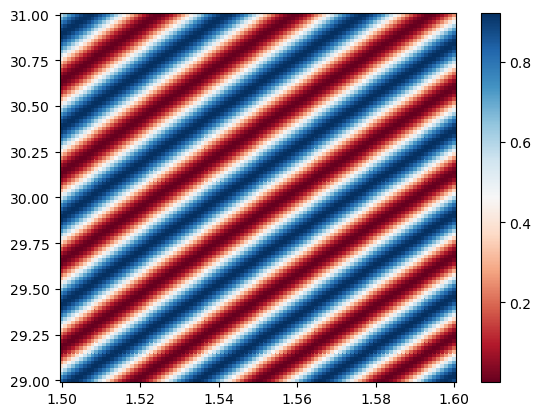

In [132]:
import matplotlib

fig, ax = plt.subplots()

p = ax.pcolor(wavelength_array, delta_length_array, loss_2D, cmap=matplotlib.cm.RdBu, vmin=abs(loss_2D).min(), vmax=abs(loss_2D).max())
cb = fig.colorbar(p, ax=ax)

NOTE: I noticed that the loss outputted by particle swarm code and the loss calculated based on output delta_length are different. In the following part, I will plot both versions of loss. 

Optimization

In [133]:
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.53)
    
delta_length = params_fn(state)
print(delta_length)

30.22716684746296


Sweep target wavelength - for initial delta length of 30 um

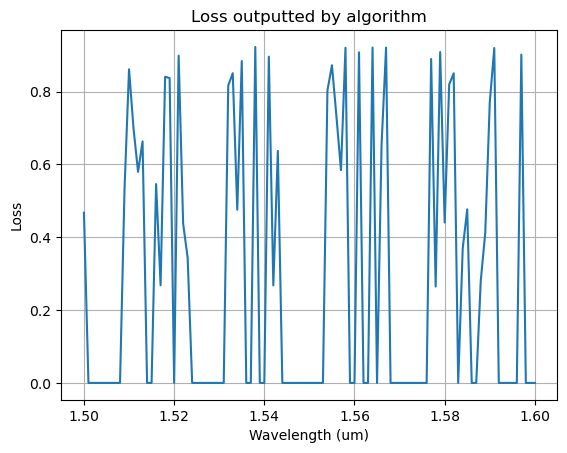

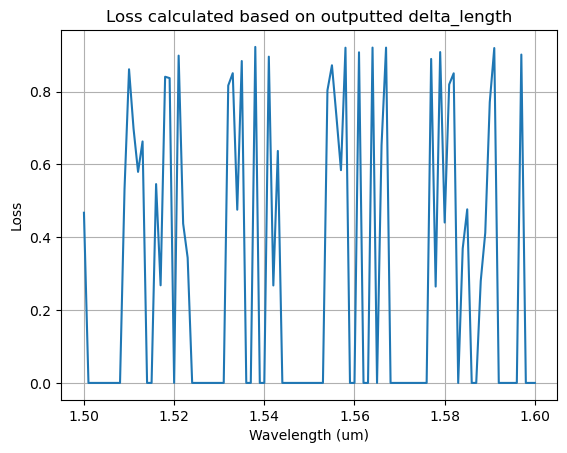

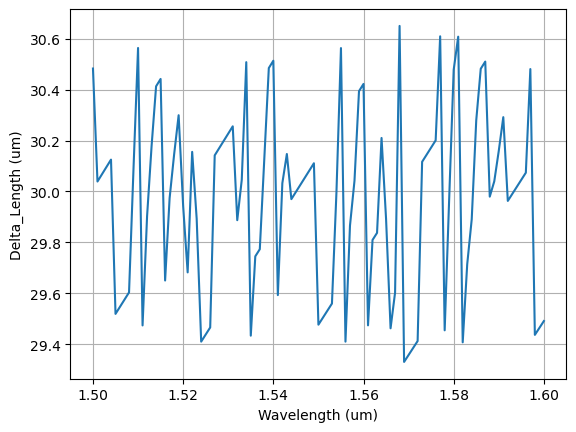

In [139]:
wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

    
for opt_wl in wavelength_array:
    initial_delta_length = 30.0
    init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
    state = init_fn(initial_delta_length)
    for step in tqdm.tqdm(range(300), total=300, disable=True):
        loss, state = step_fn(step, state, opt_wl)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(params_fn(state), opt_wl)]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Sweep target wavelength - for initial delta length of 30.5 um

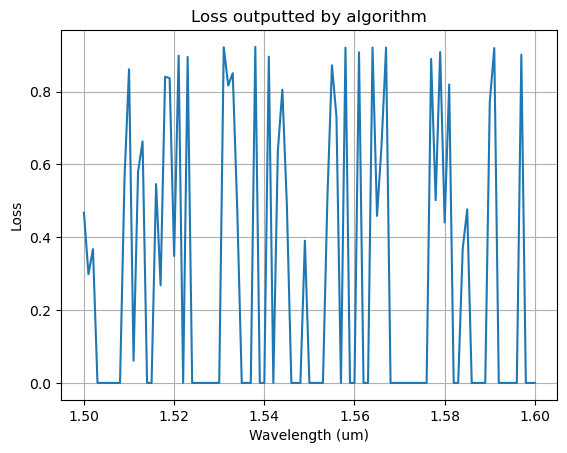

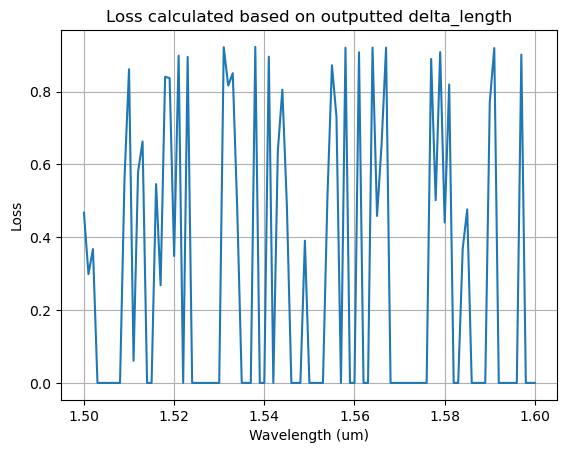

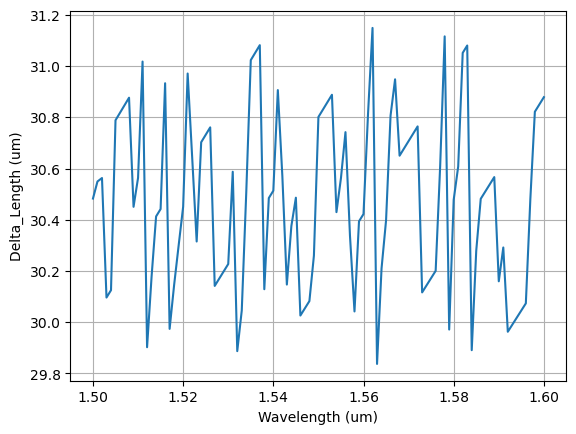

In [140]:
wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

    
for opt_wl in wavelength_array:
    initial_delta_length = 30.5
    init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
    state = init_fn(initial_delta_length)
    for step in tqdm.tqdm(range(300), total=300, disable=True):
        loss, state = step_fn(step, state, opt_wl)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(params_fn(state), opt_wl)]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Sweep target wavelength - for initial delta length of 31 um

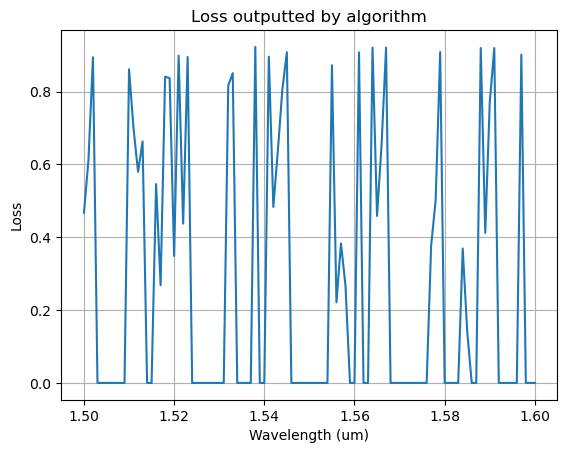

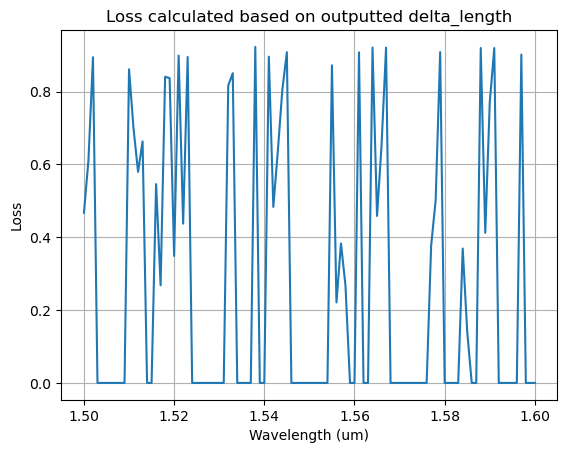

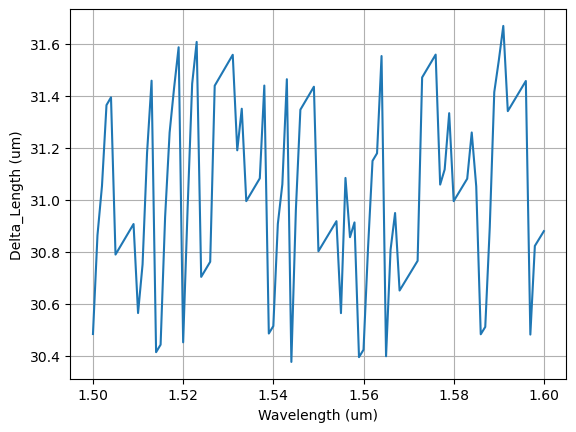

In [141]:
wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

    
for opt_wl in wavelength_array:
    initial_delta_length = 31.0
    init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
    state = init_fn(initial_delta_length)
    for step in tqdm.tqdm(range(300), total=300, disable=True):
        loss, state = step_fn(step, state, opt_wl)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(params_fn(state), opt_wl)]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Check couple of individual examples to verify there is no problem in sweep.

In [142]:
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.51)
    
delta_length = params_fn(state)
print("wavelength: 1.51 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.52)
    
delta_length = params_fn(state)
print("wavelength: 1.52 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.53)
    
delta_length = params_fn(state)
print("wavelength: 1.53 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.54)
    
delta_length = params_fn(state)
print("wavelength: 1.54 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.55)
    
delta_length = params_fn(state)
print("wavelength: 1.55 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.56)
    
delta_length = params_fn(state)
print("wavelength: 1.56 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.57)
    
delta_length = params_fn(state)
print("wavelength: 1.57 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.58)
    
delta_length = params_fn(state)
print("wavelength: 1.58 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, 1.59)
    
delta_length = params_fn(state)
print("wavelength: 1.59 um, loss: "+str(loss)+", delta_length: "+str(delta_length))

wavelength: 1.51 um, loss: 0.8613543343134743, delta_length: 30.563481893047587


wavelength: 1.52 um, loss: 6.077004059987746e-16, delta_length: 29.942604140095465
wavelength: 1.53 um, loss: 3.589344811063192e-14, delta_length: 30.22716684746296
wavelength: 1.54 um, loss: 6.571708668573921e-14, delta_length: 30.513388005793843
wavelength: 1.55 um, loss: 1.1962764882250448e-13, delta_length: 29.47649579015589
wavelength: 1.56 um, loss: 1.5731674919137344e-13, delta_length: 30.422243032529856
wavelength: 1.57 um, loss: 1.3470608125405636e-13, delta_length: 29.357493416627022
wavelength: 1.58 um, loss: 0.44050453183141214, delta_length: 30.478169406402383
wavelength: 1.59 um, loss: 0.7709174533171548, delta_length: 30.15966826854485


The success of the optimizer is strongly related to initial conditions, and at certain wavelengths, we are widely away from our target. 

What are the options? 
*   Optimizer parameters(step_size, b1, b2) [*]
*   Other optimizers (adagrad, and others) [**]

[*] https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html#jax.example_libraries.optimizers.adam

[**] https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html#jax.example_libraries.optimizers.adagrad

Parameters of adam

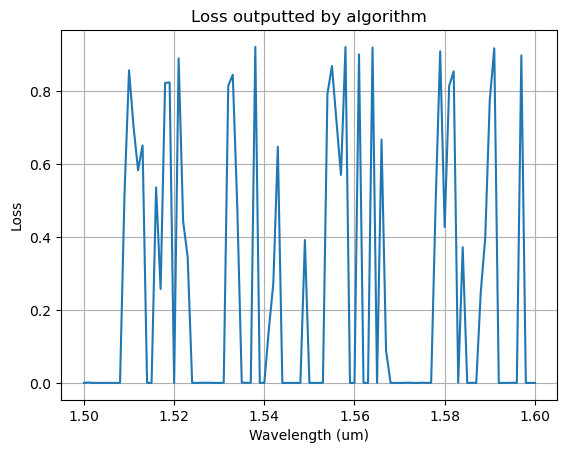

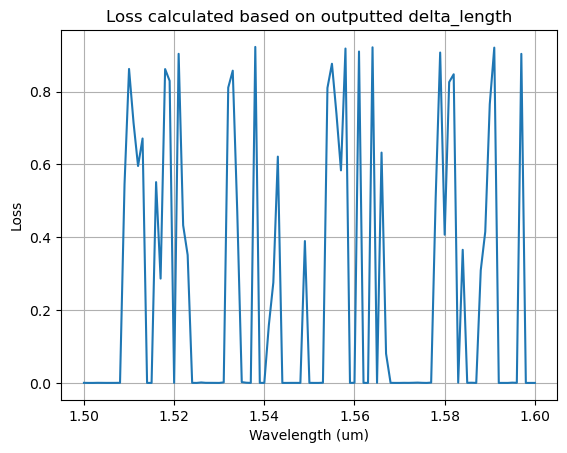

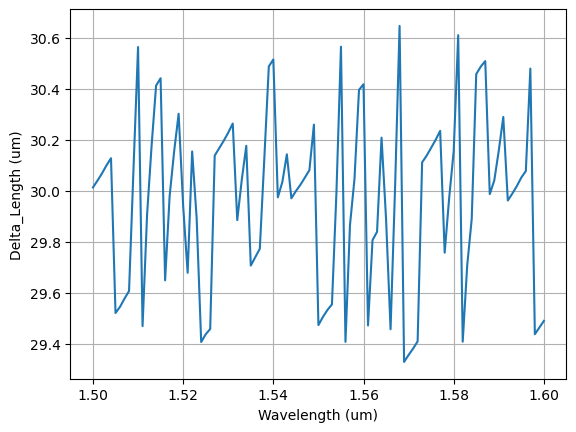

In [144]:

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []



for opt_wl in wavelength_array:
    initial_delta_length = 30.0
    init_fn, update_fn, params_fn = opt.adam(step_size=0.05, b1=0.8, b2=0.95)
    state = init_fn(initial_delta_length)
    for step in tqdm.tqdm(range(300), total=300, disable=True):
        loss, state = step_fn(step, state, opt_wl)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(params_fn(state), opt_wl)]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

AdaGrad

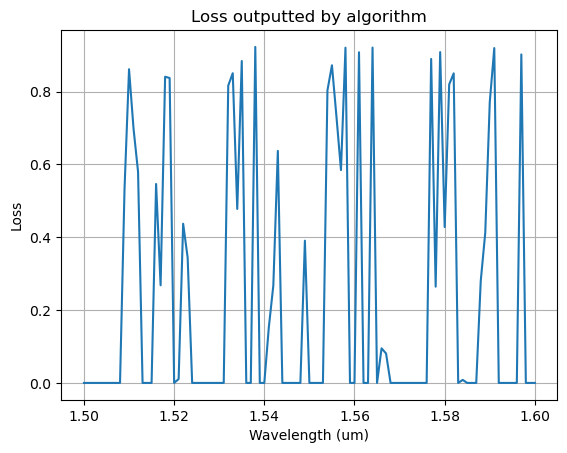

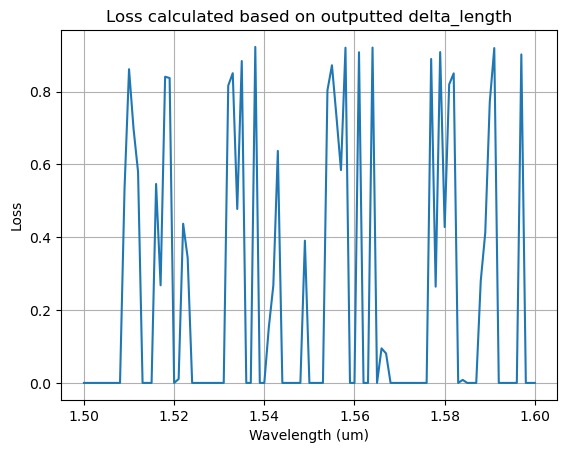

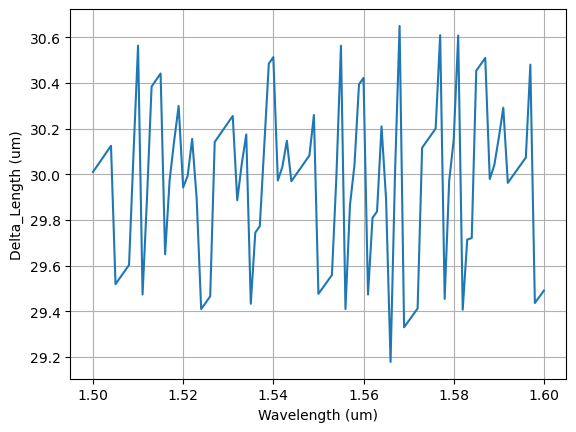

In [145]:

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []



for opt_wl in wavelength_array:
    initial_delta_length = 30.0
    init_fn, update_fn, params_fn = opt.adagrad(step_size=0.1, momentum=0.95)
    state = init_fn(initial_delta_length)
    for step in tqdm.tqdm(range(300), total=300, disable=True):
        loss, state = step_fn(step, state, opt_wl)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(params_fn(state), opt_wl)]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()






Another option is use of particle swarm optimization (using a global-best particle swarm optimization algorithm [*] here).

[*] https://pyswarms.readthedocs.io/en/latest/api/pyswarms.single.html#module-pyswarms.single.global_best

In [147]:

opt_wl = 1.53
delta_length = 30
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)

# Perform optimization
loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)

print("loss (algorithm): " +str(loss) + " , loss (calculated): " +str(loss_fn(delta_length, opt_wl)) +" , delta_length: " + str(delta_length))

optimizer.reset()


loss (algorithm): 0.20314874627084692 , loss (calculated): 0.5713234321270714 , delta_length: [30.03976019]


Wavelength sweep 

Problem in the previous version was about resetting. Still, the loss outputted by algorithm is different than loss calculated by our loss function. 

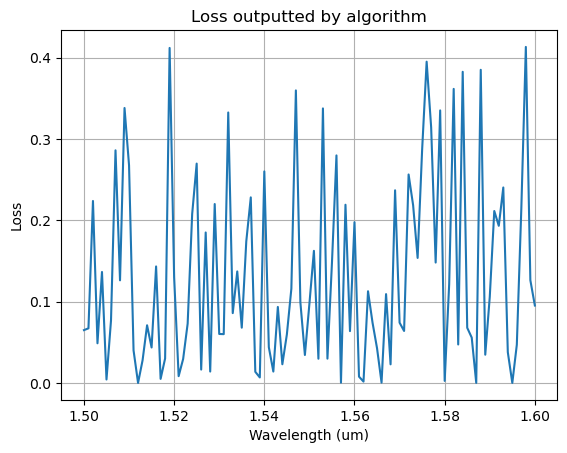

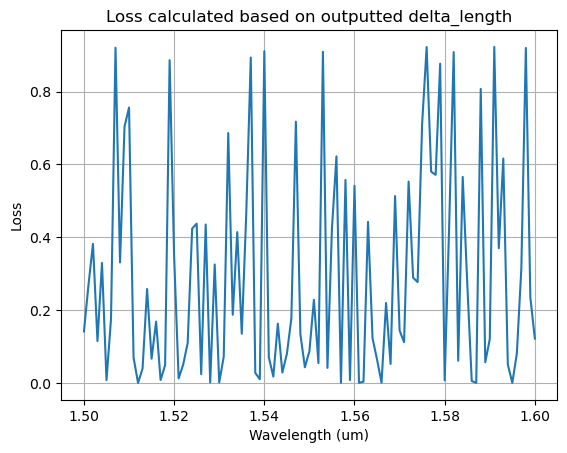

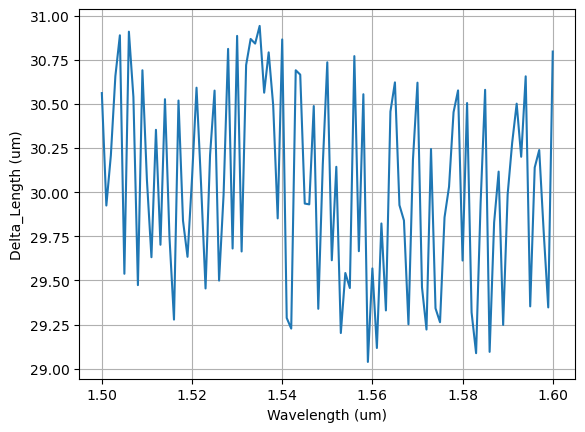

In [148]:

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Try with higher iteration number. 

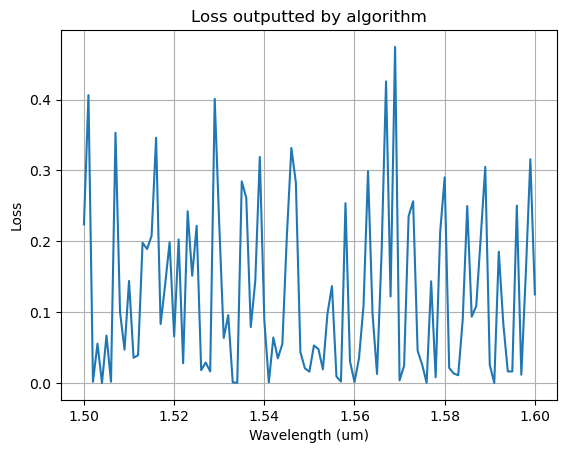

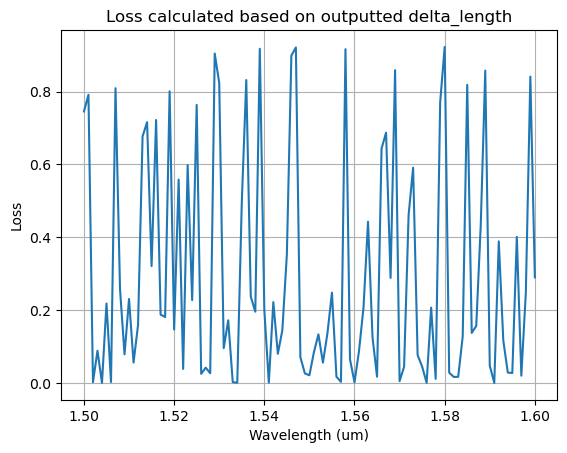

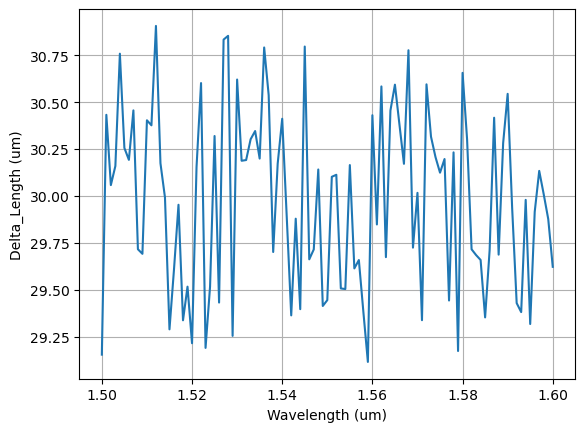

In [149]:

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=1000, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Same iteration number, second trial: 

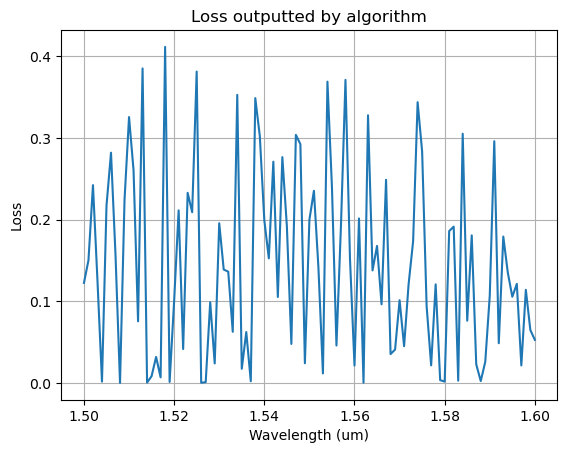

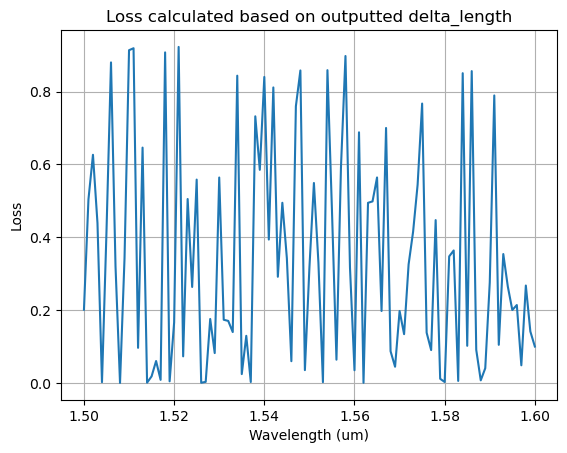

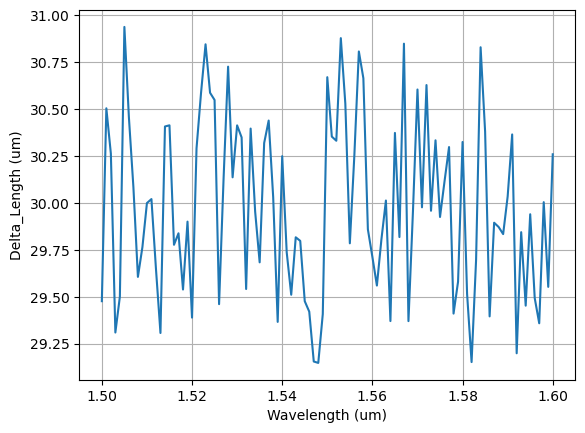

In [150]:

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=1000, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Observations: 
    
* Increasing number of iteration didn't improved the performance signicantly.
* Unlike adam optimizer, particle swarm outputs differently at each run. 


About effects of hyperparameters:

Two important parameters are c1(follow personal best) and c2(follow global best). Also, w is the inertia of swarm. [*]

[*] https://pyswarms.readthedocs.io/en/latest/api/pyswarms.single.html#module-pyswarms.single.global_best

Option Set 1

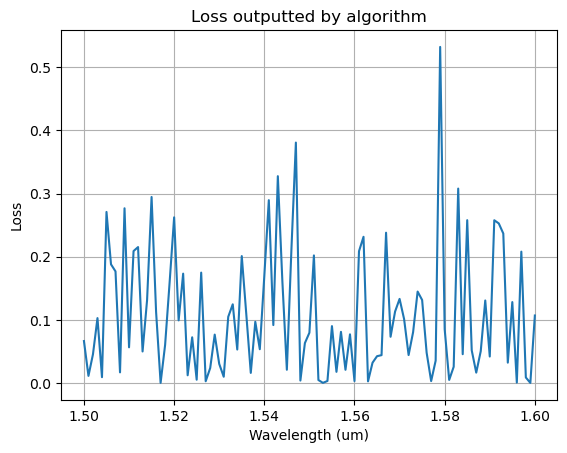

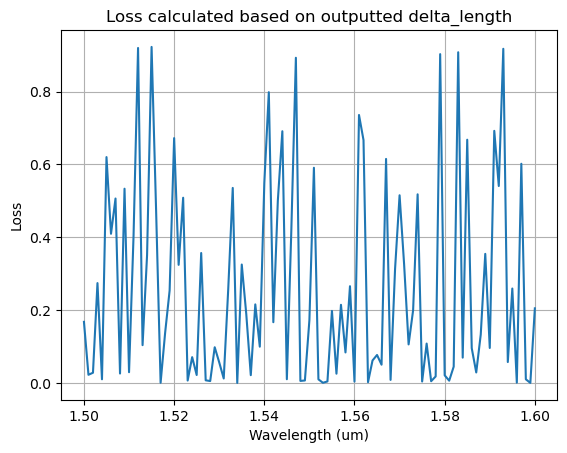

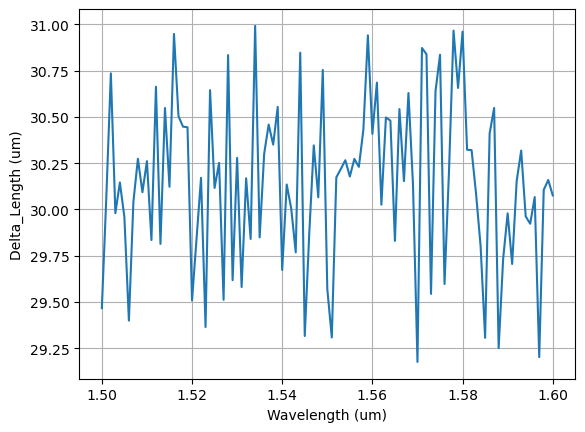

In [151]:

# Set-up hyperparameters
options = {'c1': 0.1, 'c2': 0.9, 'w':0.8}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)



wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Option Set 2

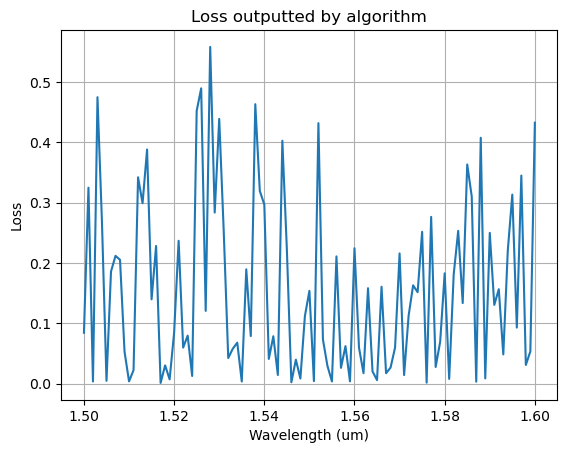

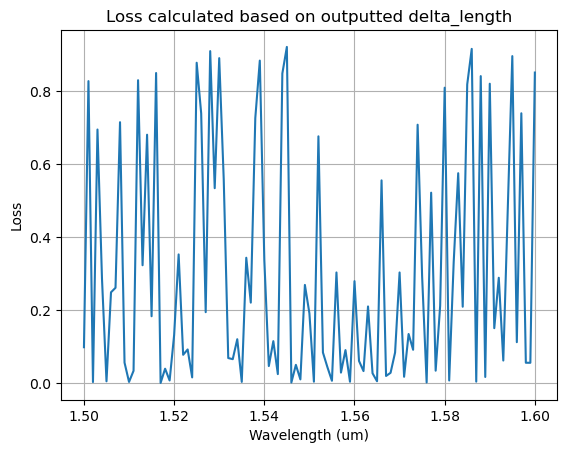

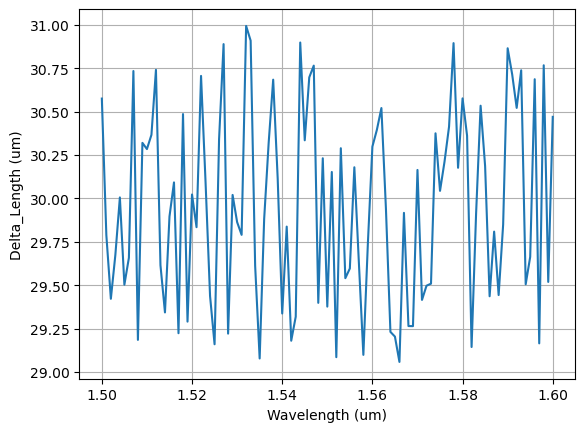

In [152]:

# Set-up hyperparameters
options = {'c1': 0.1, 'c2': 0.9, 'w':0.4}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)



wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Option Set 3

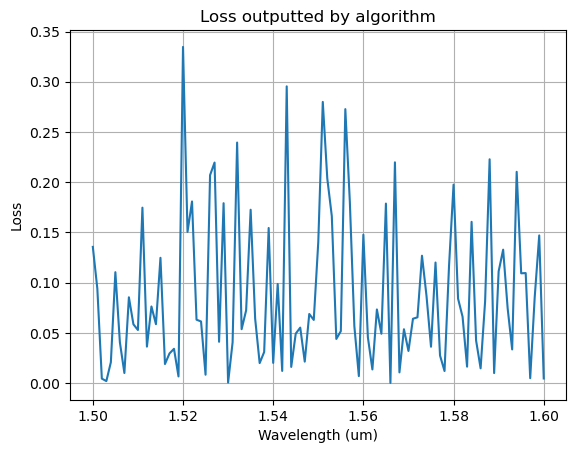

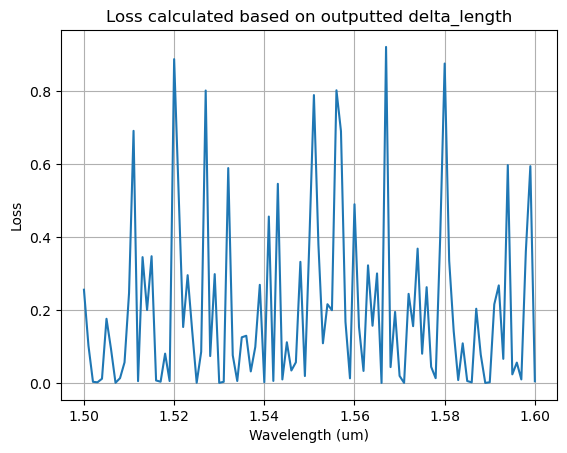

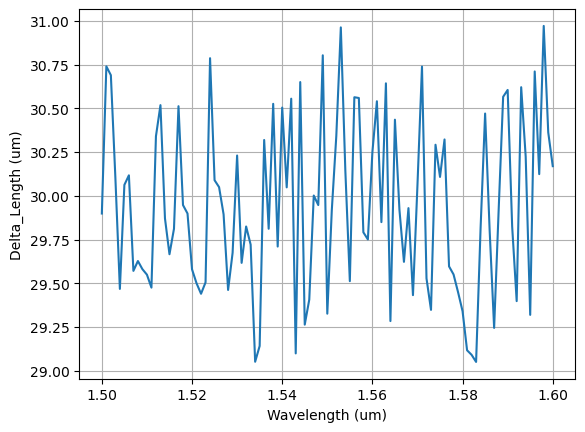

In [153]:

# Set-up hyperparameters
options = {'c1': 0.9, 'c2': 0.1, 'w':0.8}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)



wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Option Set 4: 

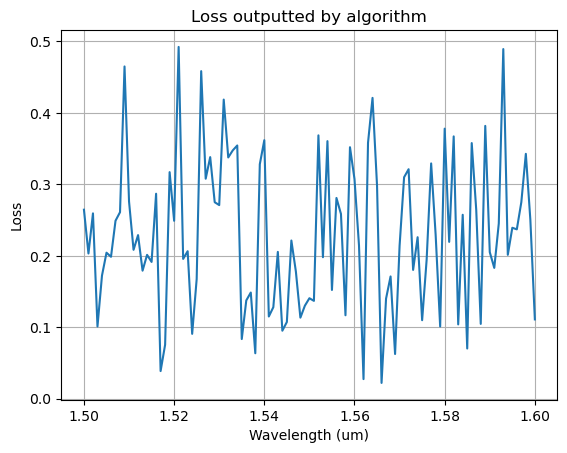

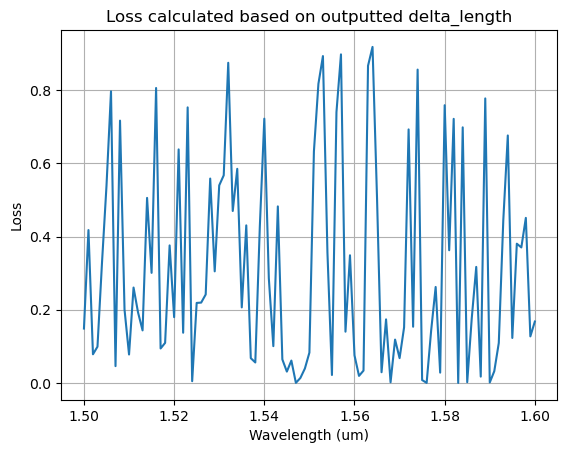

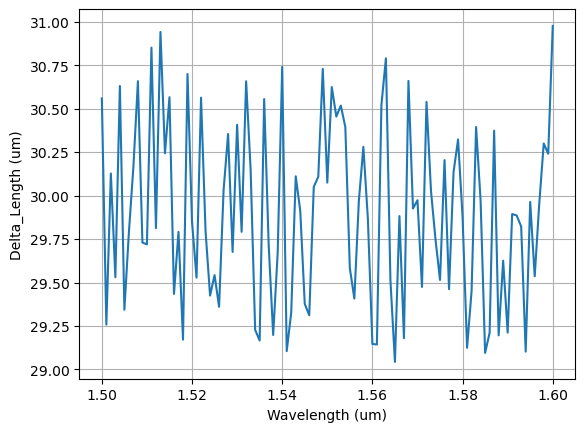

In [154]:

# Set-up hyperparameters
options = {'c1': 0.9, 'c2': 0.1, 'w':0.4}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)



wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Option Set 5

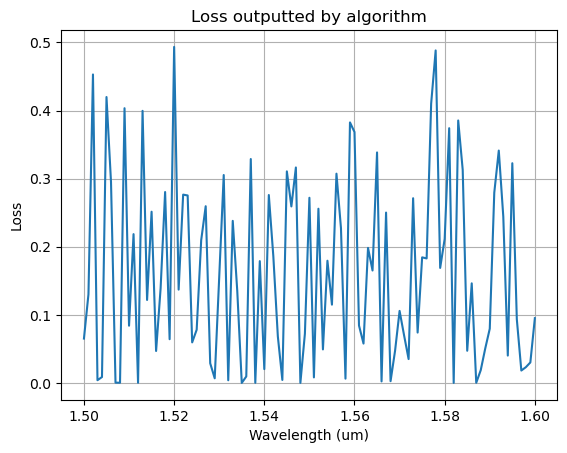

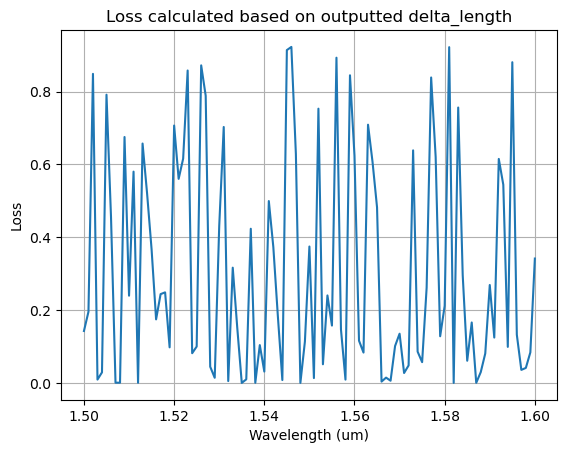

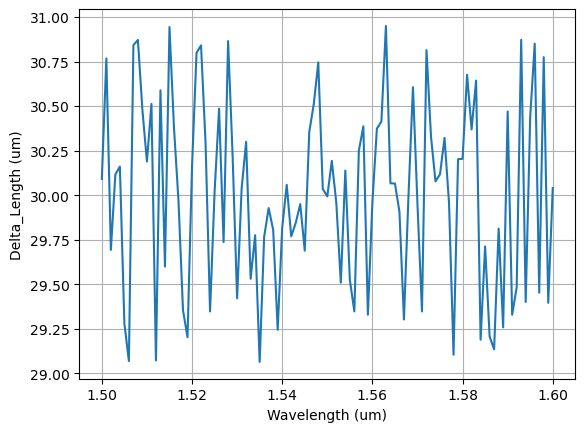

In [155]:

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.5, 'w':0.5}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)



wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array_alg = []
final_loss_array_fun = []
delta_length_array = []

for opt_wl in wavelength_array:
    delta_length = 30.0
    loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)
    final_loss_array_alg = final_loss_array_alg + [loss]
    final_loss_array_fun = final_loss_array_fun + [loss_fn(delta_length, opt_wl)]
    delta_length_array = delta_length_array + [delta_length]
    optimizer.reset()

plt.figure()
plt.plot(wavelength_array, final_loss_array_alg)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(wavelength_array, final_loss_array_fun)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

Observations: Option set 3 ( options = {'c1': 0.9, 'c2': 0.1, 'w':0.8} ) gives the best result. It is explorative.  

About convergence time: Compare adam vs particle swarm

Adam - 1.53 um

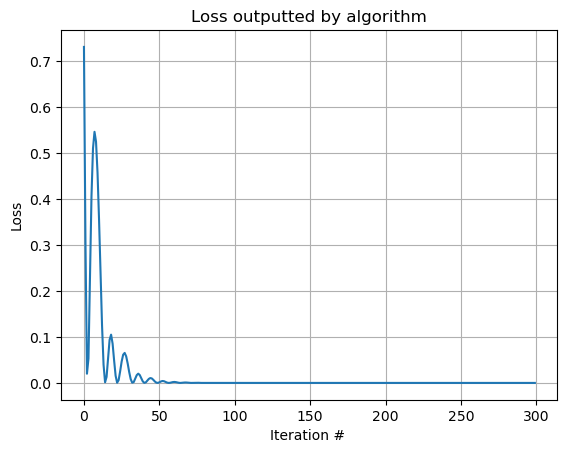

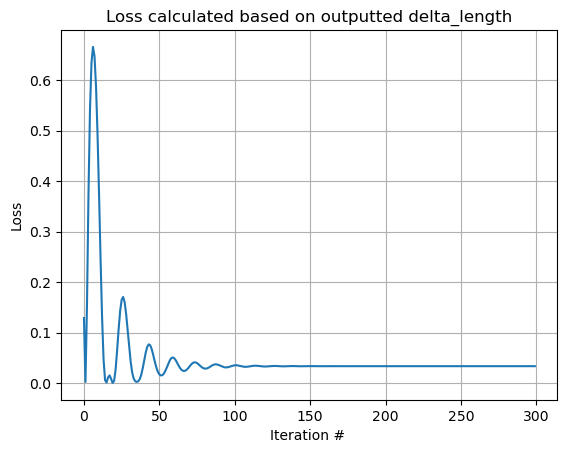

In [156]:
wavelength = 1.53
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)
loss_tracker_alg = []
loss_tracker_fun = []

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, wavelength)
    loss_tracker_alg = loss_tracker_alg + [loss]
    loss_tracker_fun = loss_tracker_fun + [loss_fn(params_fn(state), opt_wl)]

    
plt.figure()
plt.plot(loss_tracker_alg)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(loss_tracker_fun)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

Adam - 1.54 um

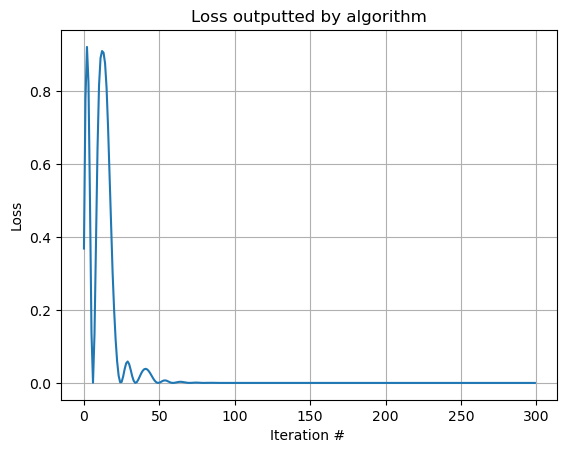

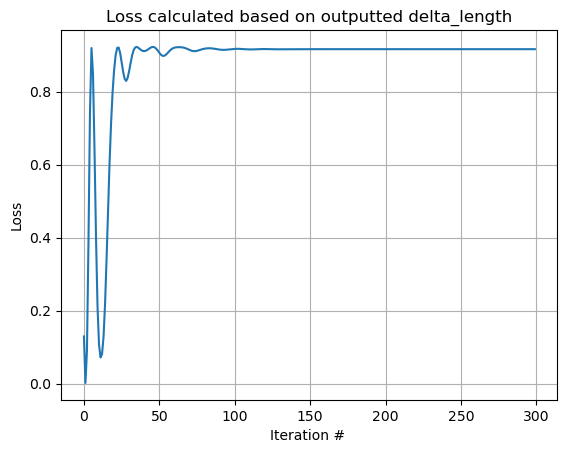

In [157]:
wavelength = 1.54
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)
loss_tracker_alg = []
loss_tracker_fun = []

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, wavelength)
    loss_tracker_alg = loss_tracker_alg + [loss]
    loss_tracker_fun = loss_tracker_fun + [loss_fn(params_fn(state), opt_wl)]

    
plt.figure()
plt.plot(loss_tracker_alg)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(loss_tracker_fun)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

Adam - 1.55 um

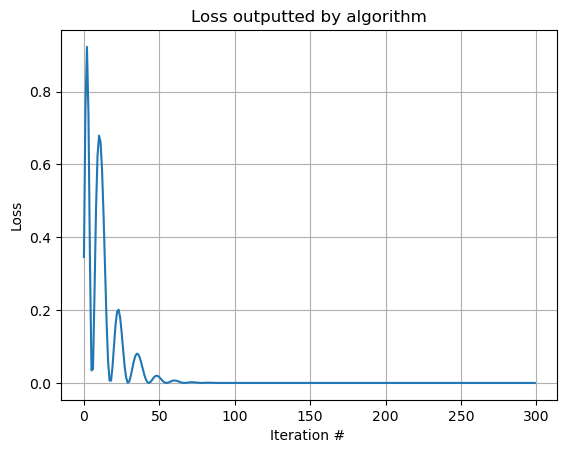

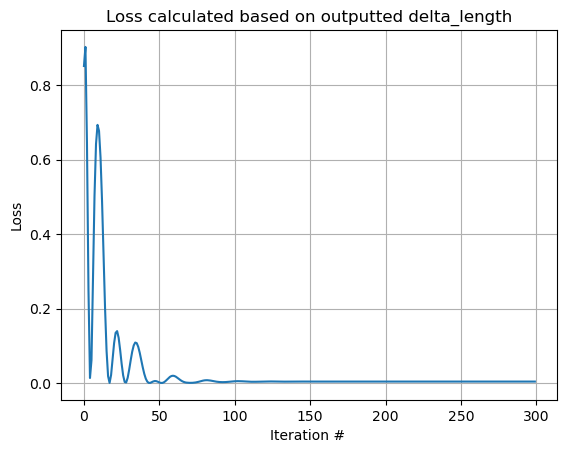

In [158]:
wavelength = 1.55
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)
loss_tracker_alg = []
loss_tracker_fun = []

for step in tqdm.tqdm(range(300), total=300, disable=True):
    loss, state = step_fn(step, state, wavelength)
    loss_tracker_alg = loss_tracker_alg + [loss]
    loss_tracker_fun = loss_tracker_fun + [loss_fn(params_fn(state), opt_wl)]

    
plt.figure()
plt.plot(loss_tracker_alg)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss outputted by algorithm")

plt.figure()
plt.plot(loss_tracker_fun)
plt.xlabel("Iteration # ")
plt.ylabel("Loss")
plt.grid()
plt.title("Loss calculated based on outputted delta_length")

Swarm - 1.53 um

loss: 0.255837417592344 , delta_length: [30.62216321]


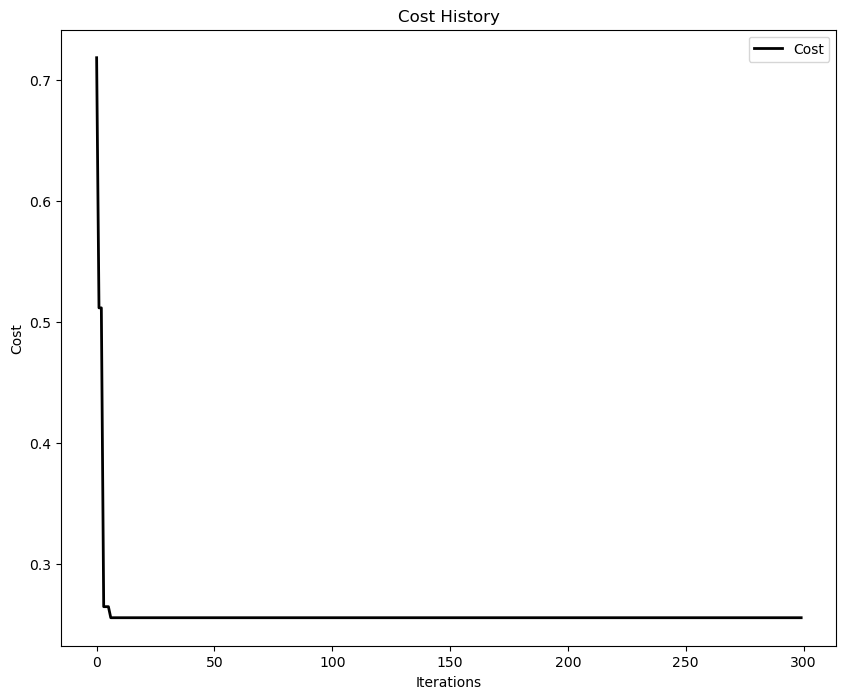

In [159]:

opt_wl = 1.53
delta_length = 30
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)

# Perform optimization
loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)

print("loss: " +str(loss) + " , delta_length: " + str(delta_length))

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
optimizer.reset()

Swarm - 1.53 um (second trial)

loss: 0.004878291519731772 , delta_length: [29.59490743]


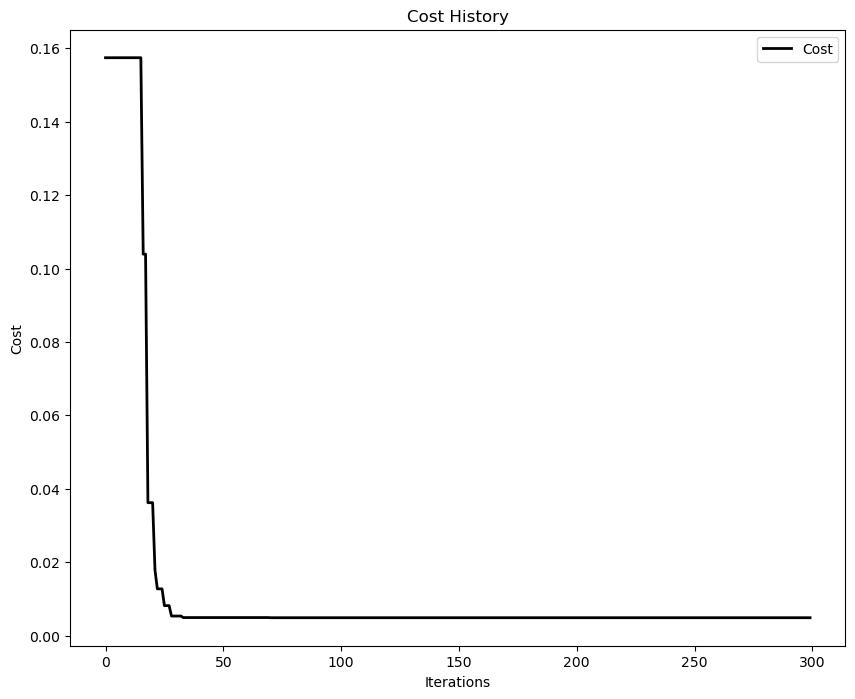

In [160]:

opt_wl = 1.53
delta_length = 30
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)

# Perform optimization
loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)

print("loss: " +str(loss) + " , delta_length: " + str(delta_length))

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
optimizer.reset()

Swarm - 1.54 um

loss: 0.3527338652921072 , delta_length: [29.66479396]


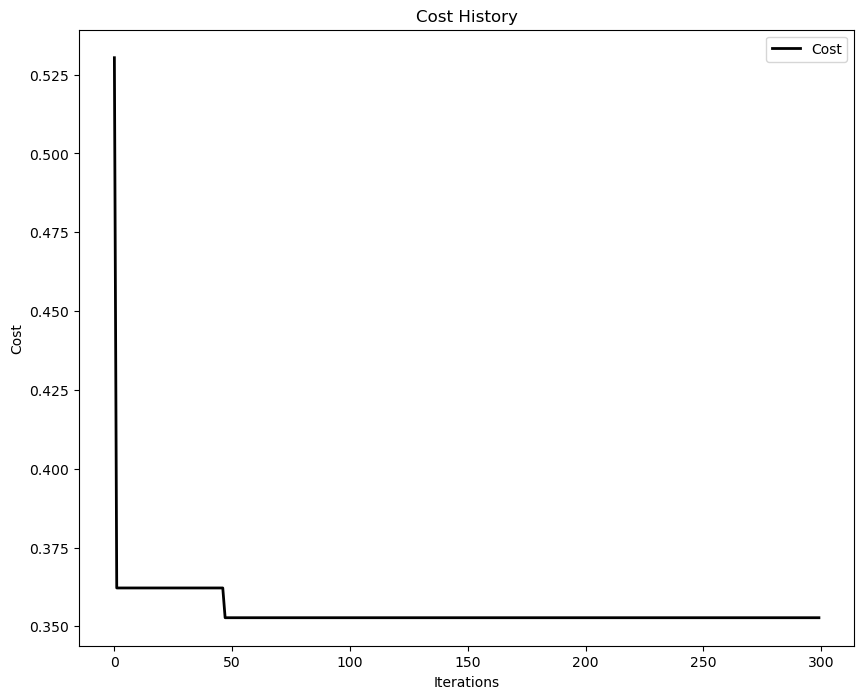

In [161]:

opt_wl = 1.54
delta_length = 30
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)

# Perform optimization
loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)

print("loss: " +str(loss) + " , delta_length: " + str(delta_length))

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
optimizer.reset()

Swarm - 1.55 um

loss: 0.14061130517843684 , delta_length: [29.30167153]


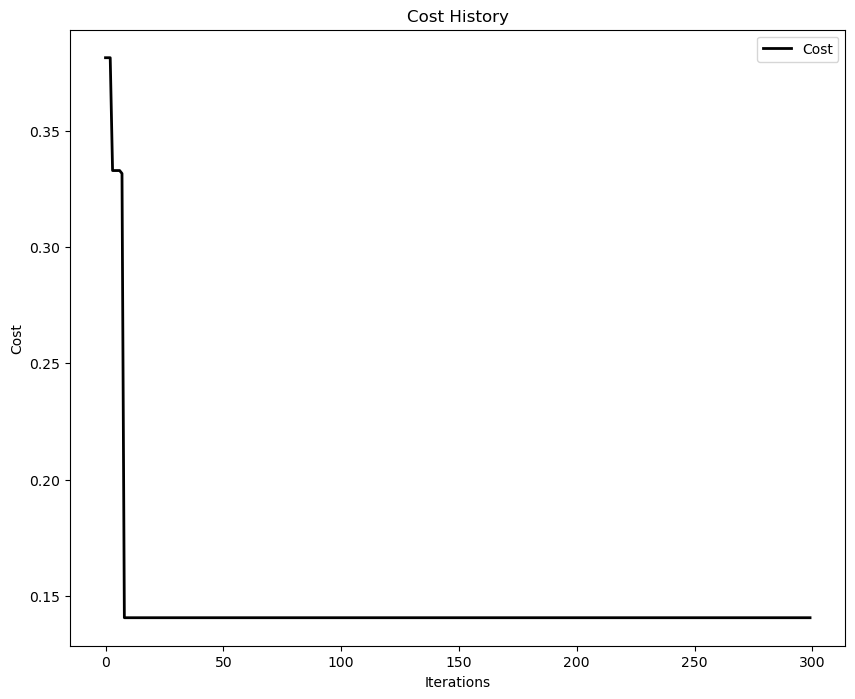

In [162]:

opt_wl = 1.55
delta_length = 30
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options=options, bounds=bounds)

# Perform optimization
loss, delta_length = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl), iters=300, verbose=False)

print("loss: " +str(loss) + " , delta_length: " + str(delta_length))

cost_history = optimizer.cost_history
plot_cost_history(cost_history)
optimizer.reset()

Observations: In general, particle swarm converges much faster than adam. 